<a href="https://colab.research.google.com/github/lmendezayl/uba-ldd-tp1/blob/main/TP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 1 - Laboratorio de Datos - 1C 2025

**Integrantes del grupo:**
- Lautaro Evaristo Mendez
- Franco Zalazar
- Luca Emilio Petrarca

In [141]:
# Si requieren mas librerias, pueden importarlas aca
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import seaborn.objects as so
import json
import plotly.express as px
import matplotlib.pyplot as plt

# manejo de error para Colab, no incluye formulaic por default
try:
    from formulaic import Formula
except:
    !pip install formulaic
    from formulaic import Formula

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge

# Si no existe root_mean_squared_error, quitarlo o actualizar scikit-learn con el comando
#!pip install scikit-learn --upgrade

Trabajaremos con el dataset `indicadores-proceso-trayectoria-sobreedad-2012_2022.csv1` que
contiene mediciones de variables educativas de la escuela primaria y secundaria en la Provincia de Buenos Aires (PBA) desde 2012 a 2022. En este [link](https://abc.gob.ar/secretarias/sites/default/files/2021-08/MANUAL%20METODOLÓGICO%20DE%20INDICADORES%20EDUCATIVOS-%202021.pdf) pueden consultar la descripción de cada variable.

In [ ]:
try:
    df_educacion = pd.read_csv('./indicadores-proceso-trayectoria-sobreedad-2012_2022.csv')
except:
    url = 'https://raw.githubusercontent.com/lmendezayl/uba-ldd-tp1/refs/heads/main/indicadores-proceso-trayectoria-sobreedad-2012_2022.csv'
    df_educacion = pd.read_csv(url)
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,alumnos_no_promovidos_primaria,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,1.45,18.54,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,0.70,9.48,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,0.69,9.13,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,1.47,8.62,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,1.58,6.95,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24


### Procesamiento de Datos

En esta primera sección, vamos implementar algunas acciones básicas de procesamiento de nuestros datos

#### Ejercicio 1
Describir el tipo de variable de cada columna

Las siguientes descripiciones fueron tomadas del link de explicacion de las variables. Aunque no sea lo pedido, creemos necesario crear una descripcion resumida de las variables con las que trabajaremos para comprension a futuro. He aquí la descripcion de cada:
- `anio`: año en el que se realizó la medición. Es de tipo `int`.
- `municipio_id`: número de identificación de cada municipio. Es de tipo `int`.
- `municipio_nombre`: nombre del municipio. Es de tipo `string`. (dice`object` pero bueno).

Las siguientes columnas reemplazan la `X` por `primaria` o por `secundaria`:
- `promocion_efectiva_X`: porcentaje de alumnos matriculados en el grado/año de estudio dado un nivel de enseñanza en particular que se matriculan como alumnos nuevos en el grado/año siguiente de ese nivel, en el año lectivo siguiente.   Tipo `float`.
    - Se calcula  `promocion_efectiva_X = 100 - repitencia_X - reinscripcion_X - abandono_interanual_X`.
- `repitencia_X`: porcentaje de alumnos matriculados en un grado/año de estudio dado de un nivel de enseñanza en particular, que se matriculan como alumnos repitentes en el mismo grado/año de estudio de ese nivel, en el año lectivo siguiente.  Tipo `float`.
- `reinscripcion_X`: porcentaje de alumnos matriculados en un grado/año de estudio dado de un nivel de enseñanza determinado, que abandonan durante el año lectivo y se vuelven a matricular como alumnos reinscriptos en el mismo grado/año de estudio de ese nivel, en el año lectivo siguiente.  Tipo `float`.
- `abandono_interanual_X`: porcentaje de alumnos matriculados en un grado/año de estudio de un nivel de enseñanza en particular, que no se vuelve a matricular al año lectivo siguiente como alumno nuevo, repitente o reinscripto. Tipo `float`.

El siguiente grupo de indicadores de medición permite medir la eficiencia de la propia escuela, elaborado a partir de nuevas preguntas incluidas en los cuadernillos del Relevamiento Anual y los Relevamientos provinciales de la PBA:
- `alumnos_promovidos_X`: porcentaje de alumnos que pasaron de grado. Tipo `float`.
    - Se calcula como `alumnos_promovidos_X = 100 - alumnos_no_promovidos_X`.
    - A diferencia del indicador tradicional de tasa de egreso (según su fórmula de cálculo, estima la probabilidad de egreso de un estudiante), este indicador mide qué porcentaje de estudiantes que asistieron hasta el último día de clases aprobaron todas las materias, ya sea en el mes de diciembre o en el período complementario de los meses de enero o febrero del año siguiente.
- `alumnos_no_promovidos_X`:  grupo de alumnos matriculados que asistieron hasta el último día de clases, pero no han cumplido con los requisitos de aprendizaje correspondientes para cursar el ciclo o año de estudio superior. Tipo `float`.
- `salidos_sin_pase_X`: proporción de alumnos que durante un ciclo lectivo determinado han salido del establecimiento sin haber pedido un pase para una escuela de destino, sobre el total de alumnos matriculados. Este grupo incluye a los alumnos que abandonaron sus estudios por cualquier motivo y a los que continúan en otra escuela sin haber realizado el trámite de pase correspondiente. Tipo `float`.
- `salidos_con_pase_X`: proporción de alumnos que durante un ciclo lectivo determinado han salido del establecimiento habiendo pedido un pase para una escuela de destino, sobre el total de alumnos matriculados. Este grupo incluye a los alumnos que abandonaron sus estudios por cualquier motivo y a los que continúan en otra escuela habiendo realizado el trámite de pase correspondiente. Tipo `float`.
- `sobreedad_X`: proporción de alumnos de educación común cuyas edades están por encima de la esperada teóricamente para el año que están cursando. Tipo `float`.
- `sobreedad_avanzada_X`: proporción de alumnos de educación común cuyas edades están, en dos años o más, por encima de lo esperado teóricamente para el año de estudio que están cursando.  Tipo `float`.

Ahora si, la lista describiendo los tipos de datos de cada variable:

In [ ]:
df_educacion.dtypes

anio                                  int64
municipio_id                          int64
municipio_nombre                     object
promocion_efectiva_primaria         float64
promocion_efectiva_secundaria       float64
repitencia_primaria                 float64
repitencia_secundaria               float64
reinscripcion_primaria              float64
reinscripcion_secundaria            float64
abandono_interanual_primaria        float64
abandono_interanual_secundaria      float64
alumnos_promovidos_primaria         float64
alumnos_promovidos_secundaria       float64
alumnos_no_promovidos_primaria      float64
alumnos_no_promovidos_secundaria    float64
salidos_sin_pase_primaria           float64
salidos_sin_pase_secundaria         float64
salidos_con_pase_primaria           float64
salidos_con_pase_secundaria         float64
sobreedad_primaria                  float64
sobreedad_secundaria                float64
sobreedad_avanzada_primaria         float64
sobreedad_avanzada_secundaria   

#### Ejercicio 2
¿La base de datos contiene datos faltantes? ¿Cuántos?

In [ ]:
df_educacion.isna().sum()

anio                                0
municipio_id                        0
municipio_nombre                    0
promocion_efectiva_primaria         0
promocion_efectiva_secundaria       0
repitencia_primaria                 0
repitencia_secundaria               0
reinscripcion_primaria              0
reinscripcion_secundaria            0
abandono_interanual_primaria        0
abandono_interanual_secundaria      0
alumnos_promovidos_primaria         0
alumnos_promovidos_secundaria       0
alumnos_no_promovidos_primaria      0
alumnos_no_promovidos_secundaria    0
salidos_sin_pase_primaria           0
salidos_sin_pase_secundaria         0
salidos_con_pase_primaria           0
salidos_con_pase_secundaria         0
sobreedad_primaria                  0
sobreedad_secundaria                0
sobreedad_avanzada_primaria         0
sobreedad_avanzada_secundaria       0
dtype: int64

La base de datos no contiene ningun dato faltante!

#### Ejercicio 3
Además de la división por municipio, nos interesa saber a que zona de la provincia pertenece cada municipio (Zona Norte, Zona Oeste , Zona Sur e Interior). Para esto:
1. Implementar una función `determinar_zona` que, dado el nombre de un municipio, devuelva a que zona pertencece: ’Norte’, ’Oeste’, ’Sur’ o ’Interior’.
2. Agregar la columna zona a `df_educacion` que contenga la zona a la que pertenece el
municipio.
*Sugerencia*: tener en cuenta el método `apply`

In [ ]:
def determinar_zona(municipio_nombre: str) -> str:
    zona_norte = ['San Isidro', 'Vicente Lopez', 'General San Martin', 'San Fernando', 'Tigre']
    zona_oeste = ['Moron', 'Tres de Febrero', 'La Matanza', 'Merlo', 'Moreno']
    zona_sur = ['Almirante Brown', 'Avellaneda', 'Quilmes', 'Lanus', 'Florencio Varela', 'Berazategui', 'Lomas de Zamora', 'Esteban Echeverria']
    zonas = {
        "Norte" : zona_norte,
        "Sur" : zona_sur,
        "Oeste" : zona_oeste}

    for zona in zonas.keys():
        if municipio_nombre in zonas[zona]:
            return zona
    return "Interior"

zonas_test = ["San Isidro", "Vicente Lopez", "Merlo", "Avellaneda", "Guernica"]
for zona in zonas_test:
    print(determinar_zona(zona))

Norte
Norte
Oeste
Sur
Interior


In [ ]:
df_educacion["zona"] = df_educacion["municipio_nombre"].apply(determinar_zona)
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria,zona
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,18.54,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28,Interior
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,9.48,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51,Interior
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,9.13,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17,Interior
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,8.62,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51,Interior
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,6.95,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24,Interior


#### Ejercicio 4

Quisiéramos analizar si en general la tasa de repitencia es más alta en primaria que en secundaria. Para esto:
1. Agregar una columna `mayor_repitencia_primaria` a `df_educacion` que indique si ocurre
esta situación.
2. Mostrar en una Serie de `pandas` cuantas veces entre los años 2017 y 2022 (inclusive) la repitencia es más alta en primaria que en secundaria para cada municipio.
3. Mostrar en un DataFrame la media de repitencia en primaria y la media de repitencia en secundaria agrupados por año y por zona.

In [ ]:
# 1
df_educacion['mayor_repitencia_primaria'] = df_educacion['repitencia_primaria'] > df_educacion['repitencia_secundaria']
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria,zona,mayor_repitencia_primaria
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28,Interior,False
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51,Interior,False
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17,Interior,False
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51,Interior,False
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24,Interior,False


In [ ]:
# 2
municipios = df_educacion['municipio_nombre'].unique() # array de todos los municipios
df_educacion_2017_2022 = df_educacion[df_educacion['anio'] >= 2017] # no hace falta poner que es menor que 2022 ya que es el maximo del conjunto de años.
cant_repitencia_2017_2022 = pd.Series()

for municipio in municipios:
    # dataframe temporal, siempre que se llame df_cache
    df_cache = df_educacion_2017_2022[df_educacion_2017_2022['municipio_nombre'] == municipio]
    cant_repitencia_2017_2022[municipio] = np.sum(df_cache['mayor_repitencia_primaria'])

cant_repitencia_2017_2022

Adolfo Alsina      1
Alberti            1
Almirante Brown    1
Arrecifes          1
Avellaneda         1
                  ..
25 de Mayo         1
Vicente Lopez      1
Villa Gesell       2
Villarino          1
Zarate             1
Length: 135, dtype: int64

In [ ]:
# 2. Mostrar en una Serie de `pandas` cuantas veces entre los años 2017 y 2022 (inclusive) la repitencia es más alta en primaria que en secundaria para cada municipio.
cant_repitencias_2017_2022 = (
df_educacion[(df_educacion['anio'] >= 2017) & (df_educacion['mayor_repitencia_primaria'] == True)]
.groupby('municipio_nombre')['mayor_repitencia_primaria']
.count()
.reindex(df_educacion['municipio_nombre'].unique(), fill_value=0)
)

np.any(cant_repitencias_2017_2022 == cant_repitencia_2017_2022)


True

In [ ]:
# 3

df_media_repitencia = (
    df_educacion
    .groupby(['anio', 'zona'])
    .agg({
        'repitencia_primaria': 'mean',
        'repitencia_secundaria': 'mean'
        })
    .reset_index()
    .rename(columns={
        'repitencia_primaria': 'media_repitencia_primaria',
        'repitencia_secundaria': 'media_repitencia_secundaria'
        })
)
df_media_repitencia.head()

,anio,zona,media_repitencia_primaria,media_repitencia_secundaria
0,2012,Interior,2.457350,10.699316
1,2012,Norte,1.634000,8.978000
2,2012,Oeste,2.346000,9.932000
3,2012,Sur,2.470000,10.208750
4,2013,Interior,1.771368,10.499402


### Regresión
En esta sección, sugerimos que, una vez realizada una Regresión, utilicen los valores de $β_0$ y $β_1$ para predecir, en vez del método `predict` de `scikit-learn`.

#### Ejercicio 1
Reproducir el siguiente gráfico sobre la evolución de la sobreedad en secundaria promedio en la Provincia de Buenos Aires a lo largo de los años:

In [ ]:
df_media_sobreedad_secundaria = df_educacion[['anio', 'sobreedad_secundaria']].copy()
df_media_sobreedad_secundaria = (
    df_media_sobreedad_secundaria
    .groupby(["anio"])
    .mean()
    .reset_index()
    .rename(columns={'sobreedad_secundaria' : 'sobreedad'})
)
df_media_sobreedad_secundaria

,anio,sobreedad
0,2012,35.344074
1,2013,32.554889
2,2014,31.719704
3,2015,30.535333
4,2016,29.719556
5,2017,28.883259
6,2018,27.584370
7,2019,26.282370
8,2020,24.578519
9,2021,22.097556


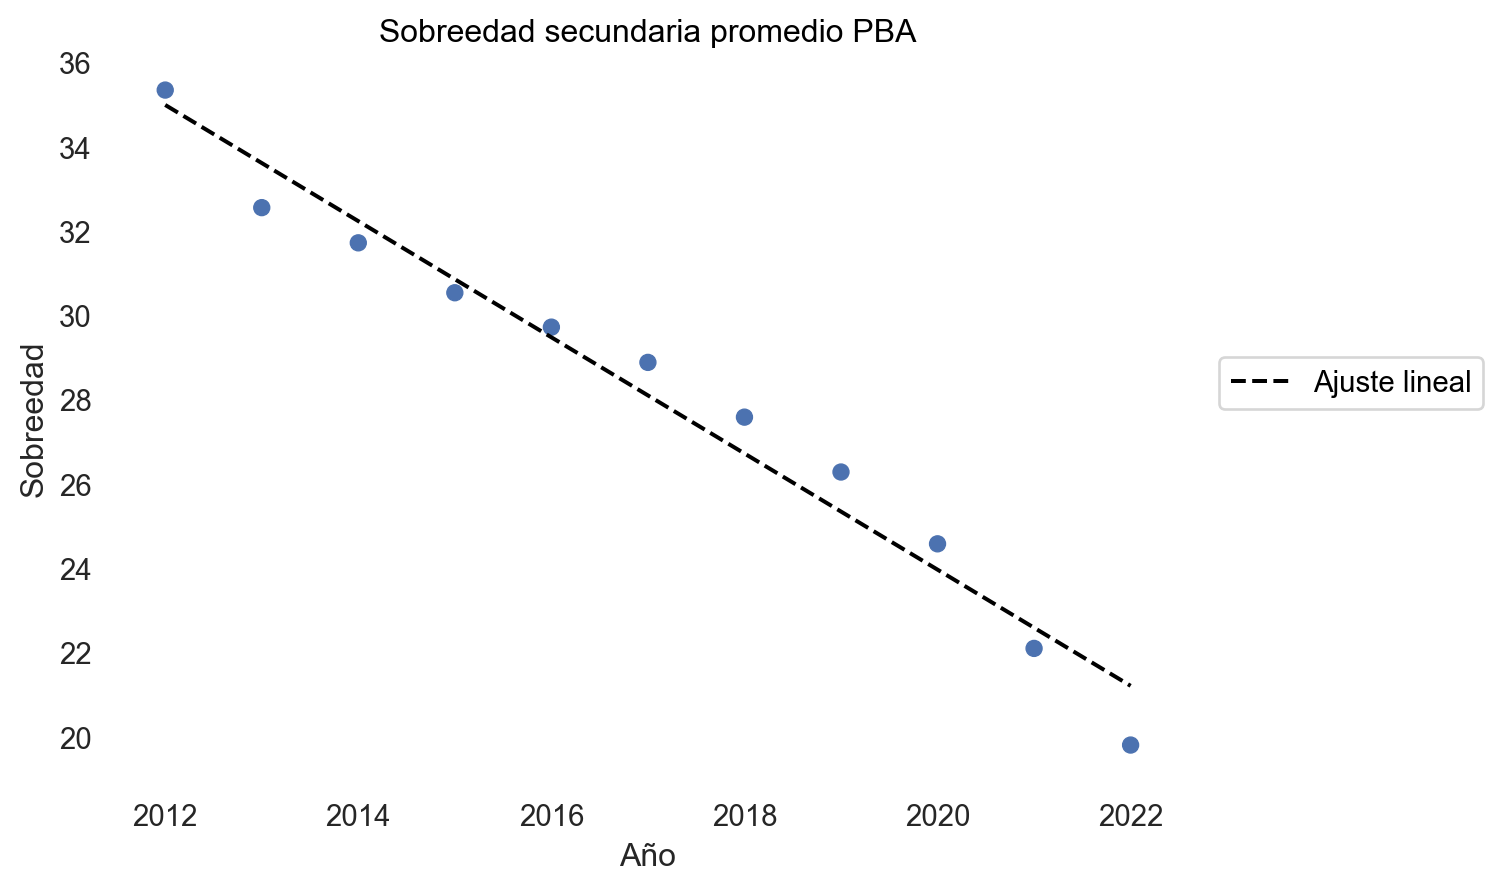

In [ ]:
(
    so.Plot(data=df_media_sobreedad_secundaria,
            x=df_media_sobreedad_secundaria["anio"],
            y=df_media_sobreedad_secundaria["sobreedad"])
    .add(so.Line(linestyle='dashed', color="black"), so.PolyFit(1), label="Ajuste lineal")
    .add(so.Dot())
    .label(
        title="Sobreedad secundaria promedio PBA",
        x="Año",
        y="Sobreedad",
    )
    .theme({"axes.facecolor": "w"}) # lo tuve que buscar: https://seaborn.pydata.org/generated/seaborn.objects.Plot.theme.html
)

#### Ejercicio 2
Realizando una Regresión Lineal, predecir para el año 2025 la sobreedad en secundaria promedio en la Provincia de Buenos Aires

In [ ]:
y, X = Formula('sobreedad ~ anio').get_model_matrix(df_media_sobreedad_secundaria)
modelo = linear_model.LinearRegression(fit_intercept=False)
modelo.fit(X, y)
beta_0, beta_1 = modelo.coef_[0]
prediccion_2025 = beta_0 + beta_1*2025
prediccion_2025

17.07558787878679

#### Ejercicio 3
Para cada municipio del Área Metropolitana, mediante Regresión Lineal, predecir la sobreedad en secundaria para el 2025. Elaborar un DataFrame indexado por el nombre del municipio, con dos columnas: `sobreedad_2025` con el resultado de la predicción para 2025
y `menor_que_promedio` que indique con un booleano si la predicción es menor al valor calculado en el ítem anterior.

**Sugerencia**: puede basarse en la siguiente estructura


In [ ]:
area_metropolitana = ['Almirante Brown', 'Avellaneda', 'Berazategui', 'Berisso', 'Brandsen', 'Campana', 'Cañuelas',
                      'Ensenada', 'Escobar', 'Esteban Echeverria', 'Exaltacion de la Cruz', 'Ezeiza',
                      'Florencio Varela', 'General Las Heras', 'General Rodriguez', 'General San Martin', 'Hurlingham',
                      'Ituzaingo', 'Jose C. Paz', 'La Matanza', 'La Plata', 'Lanus', 'Lujan', 'Lomas de Zamora',
                      'Malvinas Argentinas', 'Marcos Paz', 'Merlo', 'Moreno', 'Moron', 'Pilar', 'Presidente Peron',
                      'Quilmes', 'San Fernando', 'San Isidro', 'San Miguel', 'San Vicente', 'Tigre', 'Tres de Febrero',
                      'Vicente Lopez', 'Zarate']

In [ ]:
prediccion_data = []
menor_que_promedio_data = []
for municipio in area_metropolitana:
    df_partidos = df_educacion[df_educacion['municipio_nombre'] == municipio]
    y, X = Formula("sobreedad_secundaria ~ anio").get_model_matrix(df_partidos)
    modelo_p = linear_model.LinearRegression(fit_intercept=False)
    modelo_p.fit(X,y)
    beta_0, beta_1 = modelo_p.coef_[0]
    prediccion = beta_0 + beta_1 * 2025
    prediccion_data.append(prediccion)
    menor_que_promedio_data.append(prediccion < prediccion_2025)

predicciones_df = pd.DataFrame(
    data = {'sobreedad_2025': prediccion_data, 'menor_que_promedio': menor_que_promedio_data},
    index = area_metropolitana
)

predicciones_df.head()

,sobreedad_2025,menor_que_promedio
Almirante Brown,15.068727,True
Avellaneda,24.418727,False
Berazategui,19.230182,False
Berisso,28.410727,False
Brandsen,20.656727,False


### Visualización con datos geográficos
El objetivo de esta parte del TP es visualizar datos sobre un mapa de Buenos Aires. Para esto, utilizaremos las librerías `geopandas`, que nos permite trabajar con un .geojson como si fuera un DataFrame de `pandas`, y `plotly` para generar mapas interactivos

#### Ejercicio 1
Cargar los datos de `partidos.geojson` utilizando `geopandas`:



In [ ]:
# Cargamos el archivo de datos
try:
    geo_df = gpd.read_file('partidos.geojson')
except Exception:
    url = 'https://raw.githubusercontent.com/lmendezayl/uba-ldd-tp1/blob/main/partidos.geojson'
    geo_df = gpd.read_file(url)


Si imprimimos `geo_df` observamos que cada fila corresponde a un municipio con distintas
características y, además, hay una columna `geometry` que tiene las coordenadas de los límites de los partidos. Pueden visualizar estos datos con `geo_df.plot()`.

<Axes: >

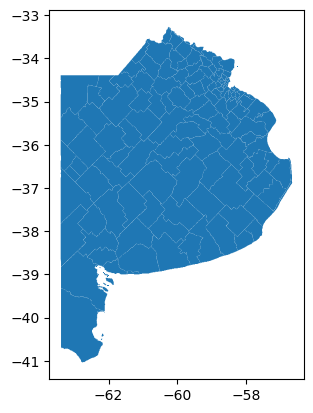

In [ ]:
# Visualizamos los partidos
geo_df.plot()

In [ ]:
geo_df.head()

,cca,cde,fna,gna,nam,sag,ara3,arl,geometry
0,045,06357,Partido de General Pueyrredón,Partido,General Pueyrredón,ARBA,1463.50,1460.74,"MULTIPOLYGON (((-57.54 -38.06, -57.53 -38.05, ..."
1,055,06441,Partido de La Plata,Partido,La Plata,ARBA,892.63,942.23,"MULTIPOLYGON (((-58.14 -34.99, -58.13 -35, -58..."
2,070,06427,Partido de La Matanza,Partido,La Matanza,ARBA,328.19,329.22,"MULTIPOLYGON (((-58.58 -34.65, -58.58 -34.65, ..."
3,030,06260,Partido de Esteban Echeverría,Partido,Esteban Echeverría,ARBA,120.45,120.22,"MULTIPOLYGON (((-58.51 -34.73, -58.51 -34.73, ..."
4,074,06560,Partido de Moreno,Partido,Moreno,ARBA,186.05,186.13,"MULTIPOLYGON (((-58.78 -34.56, -58.77 -34.56, ..."


#### Ejercicio 2
Identificar qué columna se corresponde al número de identificación de cada municipio. Mostrar
todos los municipios con números de identificación repetidos.
**Sugerencia**: utilizar el argumento `keep` del método `duplicated`

In [ ]:
# cde tiene el numero de identificacion!
print(len(geo_df['cde'].unique()))
print(len(geo_df['cde']))

nombres = pd.concat([geo_df[geo_df['cde'].duplicated(keep='last')]['nam'], geo_df[geo_df['cde'].duplicated(keep='first')]['nam']])
print("\n", nombres)


geo_df.head()

134
143

 28                  Ramallo
29              San Nicolás
35                   Zárate
38                  Campana
58                    Tigre
65                 Baradero
76                Chascomús
103            San Fernando
104               San Pedro
126          Islas Baradero
127         Islas de Zárate
128      Islas San Fernando
130           Islas Ramallo
131         Islas San Pedro
135                  Lezama
139           Islas Campana
141             Islas Tigre
142    Islas de San Nicolas
Name: nam, dtype: object


,cca,cde,fna,gna,nam,sag,ara3,arl,geometry
0,045,06357,Partido de General Pueyrredón,Partido,General Pueyrredón,ARBA,1463.50,1460.74,"MULTIPOLYGON (((-57.54 -38.06, -57.53 -38.05, ..."
1,055,06441,Partido de La Plata,Partido,La Plata,ARBA,892.63,942.23,"MULTIPOLYGON (((-58.14 -34.99, -58.13 -35, -58..."
2,070,06427,Partido de La Matanza,Partido,La Matanza,ARBA,328.19,329.22,"MULTIPOLYGON (((-58.58 -34.65, -58.58 -34.65, ..."
3,030,06260,Partido de Esteban Echeverría,Partido,Esteban Echeverría,ARBA,120.45,120.22,"MULTIPOLYGON (((-58.51 -34.73, -58.51 -34.73, ..."
4,074,06560,Partido de Moreno,Partido,Moreno,ARBA,186.05,186.13,"MULTIPOLYGON (((-58.78 -34.56, -58.77 -34.56, ..."


#### Ejercicio 3
Aplicar las siguientes modificaciones a `geo_df`:
1. eliminar las filas que correspondan a islas de partidos (por ejemplo, Islas Ramallo).
2. convertir la columna `cde` a numérica (recordar el método `astype`)
3. corregir los valores en la columna cde para los partidos de Chascomús y Lezama, para
que coincidan con sus valores en la columna `municipio_id` de `df_educacion`. **Sugerencia**: puede basarse en el siguiente código para corregir los valores:

`geo_df.loc[geo_df[???] == ???, <columna a modificar>] = ???`

Finalmente, exportar `geo_df` como un GeoJSON llamado `partidos_limpio.geojson`:

In [ ]:
df_educacion[df_educacion['municipio_nombre'] == 'Lezama']['municipio_id'].unique()[0]

6466

In [ ]:

def eliminar_islas(df):
    return df[~df['nam'].str.startswith("Islas")]

def convertir_cd_a_int(df):
    df['cde'] = df['cde'].astype(int)
    return df

def mapear_ids_chascomus_lezama(df):
    nuevo_id_chascomus = df_educacion[df_educacion['municipio_nombre'] == 'Chascomus']['municipio_id'].unique()[0]
    nuevo_id_lezama = df_educacion[df_educacion['municipio_nombre'] == 'Lezama']['municipio_id'].unique()[0]
    viejo_id_chascomus = df[df['nam'] == 'Chascomús']['cde'].unique()[0]
    viejo_id_lezama = df[df['nam'] == 'Lezama']['cde'].unique()[0]
    df['cde'].replace({viejo_id_chascomus: nuevo_id_chascomus, viejo_id_lezama: nuevo_id_lezama})
    return df

geo_df


geo_df = (
 geo_df.copy()
 .pipe(eliminar_islas)
 .pipe(mapear_ids_chascomus_lezama)
 .pipe(convertir_cd_a_int)
     )


In [ ]:
# Grabamos los datos limpios en un nuevo archivo GeoJSON
geo_df.to_file('partidos_limpio.geojson', driver='GeoJSON')

In [ ]:
# Limpieza de datos. Seguir las indicaciones en la consigna del TP para este paso.


#### Ejercicio 4
A partir del DataFrame `df_educacion`, crear un DataFrame `repit` que tenga tres colum-
nas: `cde` con el código del municipio, `municipio_nombre` con el nombre del municipio y
`repitencia_secundaria` con el promedio de repitencia en secundaria del municipio.

**Sugerencia**: Partir de `df_educacion.groupby(['municipio_id', 'municipio_nombre'])`.
Si obtienen una serie con multi-indices, pueden convertirlo a DataFrame con columnas para los índices utilizando `.reset_index()`. O si ingresan el nombre de la columna `repitencia_secundaria` entre doble corchetes, obtienen también un DataFrame con las tres columnas

In [ ]:
# Creamos un DataFrame repit con los datos de repitencia siguiendo la consigna del TP
repit  = df_educacion.groupby(['municipio_id', 'municipio_nombre'])['repitencia_secundaria'].mean().reset_index().rename(columns={"municipio_id": "cde"})
repit



,cde,municipio_nombre,repitencia_secundaria
0,6007,Adolfo Alsina,5.600000
1,6014,Adolfo Gonzales Chaves,8.960000
2,6021,Alberti,7.790000
3,6028,Almirante Brown,8.197273
4,6035,Avellaneda,9.252727
...,...,...,...
130,6854,25 de Mayo,7.293636
131,6861,Vicente Lopez,5.488182
132,6868,Villa Gesell,7.985455
133,6875,Villarino,10.423636


#### Ejercicio 5
Con el siguiente código podemos elaborar un mapa interactivo:

In [ ]:
with open('partidos_limpio.geojson', 'r') as f:
    partidos = json.load(f)

fig = px.choropleth_map(
    repit,
    geojson=partidos,
    featureidkey = 'properties.cde',
    locations='cde',
    color='repitencia_secundaria',
    zoom = 4,
    center = {"lat": -34.61315, "lon": -58.37723},
    color_continuous_scale="Bluered",
    opacity=0.7,
    hover_name="municipio_nombre"
)

fig.show()

AttributeError: module 'plotly.express' has no attribute 'choropleth_map'

Agregar argumentos a `choropleth_map` para que:
1. la escala de color sea 'Bluered' (pueden ver otras escalas de color en este link)
2. la opacidad del color sea de 0.7
3. que al pasar el cursor sobre un partido, se muestre también su nombre

In [ ]:
# Generamos un gráfico interactivo para el nivel de repitencia

# Si no existe chorpleth_map o alguna opcion del codigo en la siguiente celda, actualizar plotly con el siguiente comando y reiniciar el kernel.
#!pip install plotly --upgrade

# Si tienen algún error de Java después de instalar los paquetes actualizados y reiniciar el kernel, prueben refrescar el navegador con CTRL+F5.

### Análisis exploratorio

La idea de este ítem es que realicen un análisis exploratorio de los datos, aplicando las herramientas de visualización (seaborn.objects, seaborn y/o matplotlib), de resumen de datos (media, mediana, desvío estándar, operaciones sobre el DataFrame, etc.) y/o de Regresión.
El objetivo es entender, comparar y/o estudiar aspectos en los indicadores educativos de los partidos de la Provincia de Buenos Aires. Algunas preguntas disparadoras pueden ser:
- ¿Existe alguna relación entre la repitencia y los fondos enviados al partido para la educación?
- ¿Podemos explicar por qué hay algunos partidos con repitencia muy superior al promedio?
- ¿Qué relación hay entre la cantidad de habitantes y la cantidad de establecimientos educativos?
-
No es necesario que respondan a cada una de esas preguntas (ni se limiten a eso), lo mejor es que exploren por donde se les ocurra. Alentamos que se planteen hipótesis y usen los datos para corroborarlas o rechazarlas. Pueden aplicar cualquiera de las herramientas que hemos visto hasta ahora. Asimismo, pueden centrarse en un conjunto de partidos, en un conjunto de indicadores educativos, etc.

A continuación dejamos otros datasets que pueden serles de ayuda (su uso es opcional):
- [Establecimientos educativos](https://catalogo.datos.gba.gob.ar/dataset/establecimientos-educativos)
- [Población](https://catalogo.datos.gba.gob.ar/dataset/poblacion)
- [Transferencias a Consejos Escolares](https://catalogo.datos.gba.gob.ar/dataset/tranferencias-consejos-escolares)
- [Transferencias a municipios](https://catalogo.datos.gba.gob.ar/dataset/transferencias-municipios)

También pueden explorar datasets del Gobierno Nacional o de la Ciudad de Buenos Aires (pero
que el análisis esté centrado en PBA).


**Importante**: en el Notebook, las visualizaciones y resúmenes de datos que realicen deben
estar acompañados por las conclusiones que obtengan a partir de ellos.

#### Planteo del problema

En este análisis intentaremos dar una respuesta a la siguiente hipótesis:
> *Los municipios con peores condiciones habitacionales en 2022 tienen mayores tasas de abandono y/o repitencia en 2022.*

Nos parece buen puntapié como hipótesis, ya que la precariedad habitacional suele estar relacionada con la vulnerabilidad socioeconómica, que impacta en la asistencia y desempeño escolar.

Partiendo de esto, añadimos como posible continuación del problema ver si podemos entrenar un modelo que a partir de los datos de condiciones habitacionales de 2022, sea capaz de predecir algunas de las tasas que se encuentran en `df_educacion` para el año 2022.

Como solo tenemos datos sobre las condiciones habitacionales del último censo, tenemos una limitación muy estricta. Debido a esto, la metodología que usaremos será tomar el 85% de los partidos en la Pcia. de Bs. As. y entrenar al modelo, para luego verificar con el 15% de los partidos restantes si el modelo predice correctamente las tasas de los partidos de verificación.

A su vez, intentaremos dar una estimación preliminar sobre los datos de educación de 2023 usando el modelo y asumiendo que las condiciones habitacionales se mantienen constantes, pero no podremos verificarlos pues no hay datos publicados de 2023 aún. La elección de 2023 no es arbitraria, está claro que a más alejado el año se encuentra de 2022, mayor es el error de la predicción realizada por el modelo. Por otro lado, no podemos intentar predecir los datos de 2021 y de 2020, ya que poseen un sesgo muy marcado por la pandemia de COVID-19 y es por este motivo que deben ser considerados casos aislados. Años pre-pandemia no son comparables debido a diferencias estructurales en el sistema educativo, como la virtualidad como norma, colegios menos restrictivos, entre otros cambios. Por esto mismo, debe ser considerado como una predicción basada en patrones observados más que en relaciones causales.  

Para ello, como mencionamos anteriormente, haremos uso de los datos publicados en ["*Censo Nacional de Población, Hogares y Viviendas 2022, Resultados provisionales, Indicadores de las condiciones habitacionales de las viviendas particulares ocupadas*"](https://www.indec.gob.ar/ftp/cuadros/poblacion/cnphv2022_condiciones_habitacionales_05_23A5A5DCDF38.pdf). En particular, nos interesa el apartado de estadísticas de la Provincia de Buenos Aires, en las páginas 14 a 17 (inclusive).

Lo siguiente es una breve descripción de las columnas presentes en la base de datos `df_censo_2022_cond_hab`:

- **Pisos con revestimiento**: el material predominante de los pisos es cerámica, mosaico, baldosa, alfombra, madera, flotante, vinílico, microcemento, cemento alisado o mármol.
- **Agua por cañería dentro de la vivienda**: tiene agua por cañería dentro de la vivienda.
- **Agua para beber y cocinar por red pública**: el agua que usa para beber y cocinar proviene de red pública (agua corriente).
- **Baño o letrina dentro de la vivienda**: tiene baño o letrina dentro de la vivienda.
- **Dos o más baños**: tiene dos o más baños.
- **Baño con inodoro con arrastre de agua**: tiene baño que posee inodoro con botón, mochila o cadena (arrastre de agua).
- **Desagüe del inodoro a red pública**: tiene desagüe del inodoro a red pública (cloaca).
- **Gas de red o electricidad para cocinar**: utiliza para cocinar principalmente gas de red o electricidad.
- **Vivienda propia**: la vivienda es propia.
- **Internet**: tiene internet.
- **Celular con internet**: tiene celular con internet.
- **Computadora o tablet u otros**: tiene computadora, tablet, etcétera.


#### Pasos iniciales

En primer lugar, debemos importar el dataset con el que trabajaremos, el cual fue parseado a archivo .csv y ordenado para su uso. También verificamos si existe algun valor NaN, que no debería suceder si fue creado correctamente por nosotros.

In [ ]:
# Importamos el dataset
# manejo de error por si estamos en local o no
try:
    df_censo_2022_cond_hab = pd.read_csv("indec_2022_condiciones_habitacionales.csv")
except:
    url = 'https://raw.githubusercontent.com/lmendezayl/uba-ldd-tp1/refs/heads/main/indec_2022_condiciones_habitacionales.csv'
    df_censo_2022_cond_hab = pd.read_csv(url)

# Chequeamos que no hayan datos NaN, como solo da [False] significa que no hay datos NaN
print(df_censo_2022_cond_hab.isna().any().unique())


[False]


En efecto, no hay datos nulos.

Echémosle un vistazo a los datos con los que trabajaremos:

In [ ]:
display(df_censo_2022_cond_hab.head())

,Partido,Pisos con revestimiento,Agua por canieria dentro de la vivienda,Agua para beber y cocinar por red publica,Banio o letrina dentro de la vivienda,Dos o mas banios,Banio con inodoro con arrastre de agua,Desague del inodoro del banio a red publica,Gas de red o electricidad para cocinar,Vivienda propia,Internet,Celular con internet,Computadora o tablet u otros
0,Almirante Brown,83.7,90.5,54.8,96.3,20.3,85.4,41.4,65.1,73.3,83.0,91.6,55.9
1,Avellaneda,92.9,96.4,96.6,96.4,23.7,94.3,81.1,78.2,64.0,85.6,92.4,65.3
2,Berazategui,85.8,95.0,89.8,96.7,23.1,90.0,77.1,67.4,71.1,86.3,92.7,58.3
3,Esteban Echeverría,81.1,89.4,61.0,95.9,23.3,84.8,50.4,61.2,70.4,82.4,92.1,54.5
4,Ezeiza,78.0,87.7,49.4,96.0,20.0,82.8,35.7,55.0,72.9,76.8,91.7,51.4


 Antes de crear el modelo, debemos limpiar, preprocesar, y filtrar los datos para lograr lo que deseamos. Primero, limpiemos los datos y normalizemos el formato.

#### Limpieza y normalización de datos


Para facilitar el merge entre nuestro dataset y la subtabla de `df_educacion` con datos de 2022 que crearemos luego, normalizamos los nombres de los municipios eliminando tildes y unificando el nombre de la columna. También ordenamos el dataframe.


In [ ]:
import re
cambiar_tildes = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u", "ü": "u"}
pattern = re.compile("|".join(cambiar_tildes.keys())) # lo busque, no tengo idea como funciona una regex perdon

# Funcion para sacar tildes de nombres
def destildar(texto):
    return pattern.sub(lambda x: cambiar_tildes[x.group()], texto)

# Limpiamos tildes de nombres de partidos por letras sin tilde
df_censo_2022_cond_hab['Partido'] = df_censo_2022_cond_hab['Partido'].apply(destildar)

# Formateamos la tabla
df_censo_2022_cond_hab = (
    df_censo_2022_cond_hab
    .rename(columns={"Partido" : 'municipio_nombre'}) # Igualamos nombre de columna de df_educacion para poder realizar un merge
    .set_index('municipio_nombre')
    .sort_index()
    .reset_index()) # un poco de tira y afloja con municipio_nombre porque no sabia hacerlo sino

Verificamos que tengamos los mismos municipios en ambas tablas poder hacer un merge usando una comparacion con un set para poder ignorar orden de datos.


In [ ]:
set_censo = set(df_censo_2022_cond_hab['municipio_nombre'].unique().tolist())
set_educ = set(df_educacion['municipio_nombre'].unique().tolist())
print(set_censo == set_educ)

True


Entonces, como ambas columnas tienen los mismos municipios, usar el metodo `sort_index()` al crear la tabla en ambos casos garantiza el mismo orden de valores, y de esta forma crear una matriz de correlacion que sea valida.

A continuacion creamos la subtabla de `df_educacion` que solo contenga los datos de 2022 mencionada anteriormente con las columnas que nos sirven:

In [ ]:
df_educacion_2022 = (
    df_educacion[df_educacion['anio'] == 2022]
    .set_index('municipio_nombre') # hacemos el mismo proceso de indexacion que para df_censo_2022_cond_hab
    .sort_index()
    .reset_index()
    .drop(columns = ['anio', 'zona', 'mayor_repitencia_primaria']))

Por una cuestion de minimizar la perdida de datos, es conveniente crear un mapeo entre los nombres y los ID de municipio, ya que en el siguiente paso borraremos la columna de nombres para no tener que trabajar con datos tipo string.

In [ ]:
mapa_nombre_id = dict(zip(df_educacion_2022['municipio_id'], df_educacion_2022['municipio_nombre']))

# Por ejemplo, si queremos ver cual es el municipio con id=6854:
mapa_nombre_id[6854]

'25 de Mayo'

#### Preprocesamiento de los datos



Una vez que asignamos un ID unico a cada municipio, ya no es necesario trabajar con los nombres. Si en algún momento necesitamos consultar el nombre original, podemos usar el diccionario `mapa_nombre_id`.

También normalizamos los datos del censo para que estén en el rango [0, 1].

Ambos DataFrames ahora están ordenados de forma consistente, por lo que podemos agregar el `municipio_id` al DataFrame del censo y realizar `merge` usando esa clave.


In [ ]:
# Eliminamos los nombres de municipios, ya no los necesitamos
df_educacion_2022 = df_educacion_2022.drop(columns='municipio_nombre')
df_censo_2022_cond_hab = df_censo_2022_cond_hab.drop(columns='municipio_nombre')

# Normalizamos los datos del censo (de 0 a 1)
df_censo_2022_cond_hab = df_censo_2022_cond_hab/100

# Agregamos el ID de municipio al dataframe del censo
df_censo_2022_cond_hab["municipio_id"] = df_educacion_2022['municipio_id']

# Merge final para obtener el dataframe combinado
df = pd.merge(df_censo_2022_cond_hab, df_educacion_2022, on='municipio_id', how="inner")

# Reordenamos las columnas
# NOTA: SI QUEDA TIEMPO, CAMBIAR ESTO POR DF.COLUMNS Y HACER UN DICT APRA CAMBIAR EL NOMBRE DE LAS COLUMNAS
df = df[['municipio_id', 'Pisos con revestimiento',
       'Agua por canieria dentro de la vivienda',
       'Agua para beber y cocinar por red publica',
       'Banio o letrina dentro de la vivienda', 'Dos o mas banios',
       'Banio con inodoro con arrastre de agua',
       'Desague del inodoro del banio a red publica',
       'Gas de red o electricidad para cocinar', 'Vivienda propia', 'Internet',
       'Celular con internet', 'Computadora o tablet u otros',
       'promocion_efectiva_primaria', 'promocion_efectiva_secundaria',
       'repitencia_primaria', 'repitencia_secundaria',
       'reinscripcion_primaria', 'reinscripcion_secundaria',
       'abandono_interanual_primaria', 'abandono_interanual_secundaria',
       'alumnos_promovidos_primaria', 'alumnos_promovidos_secundaria',
       'alumnos_no_promovidos_primaria', 'alumnos_no_promovidos_secundaria',
       'salidos_sin_pase_primaria', 'salidos_sin_pase_secundaria',
       'salidos_con_pase_primaria', 'salidos_con_pase_secundaria',
       'sobreedad_primaria', 'sobreedad_secundaria',
       'sobreedad_avanzada_primaria', 'sobreedad_avanzada_secundaria']]

#### Análisis de correlación entre variables

Ya contamos con la base de datos formada, lo que nos permite comenzar a explorar las relaciones entre las variables. En particular, queremos identificar qué indicadores del censo podrían estar relacionados con indicadores de `df_educacion` con el objetivo de elegir nuestras tasas objetivo a predecir en el modelo.

Para ello, utilizamos un **heatmap** que nos permite visualizar de forma intuitiva y con colores qué variables están más correlacionadas entre sí.


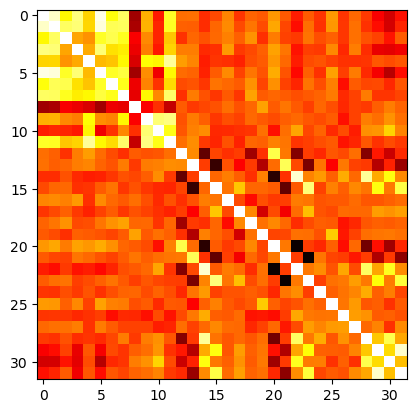

In [ ]:
# Creamos matriz de correlacion sin municipio_id
df_corr = df.drop(columns=['municipio_id']).corr()

# Creamos el heatmap
plt.imshow(df_corr,cmap='hot',interpolation='nearest')

No nos dice mucho este heatmap...

Veamos qué podemos mejorar. Nos interesaría identificar:
- qué variable educativa está **más correlacionada** con cada variable del censo.
- qué variable educativa está **menos correlacionada** con cada una.

Para eso, filtramos la matriz de correlación para quedarnos solo con los cruces entre ambos grupos de variables, ignorando las autocorrelaciones.


In [ ]:
# Filtramos la matriz de correlacion: filas = variables del censo, columnas = educativas
df_corr_subset = df_corr.iloc[:12, 12:]

# Reemplazamos los valores de autocorrelación (valor 1) por NaN para que no lo tomen como maximo/minimo
df_corr_subset = df_corr_subset.replace(1, np.nan)

# Maxima correlacion por variable del censo
max_values = df_corr_subset.max(axis=1)
max_columns = df_corr_subset.idxmax(axis=1)

# Minima correlacion por variable del censo
min_values = df_corr_subset.min(axis=1)
min_columns = df_corr_subset.idxmin(axis=1)

# Mostramos un dataframe para ver mejor los datos
display(pd.DataFrame({
    'Indicador con mayor correlacion positiva': max_columns,
    'Valor': max_values,
    'Indicador con mayor correlacion negativa': min_columns,
    'Valor ': min_values}))

,Indicador con mayor correlacion positiva,Valor,Indicador con mayor correlacion negativa,Valor
Pisos con revestimiento,salidos_sin_pase_secundaria,0.194875,sobreedad_avanzada_primaria,-0.404797
Agua por canieria dentro de la vivienda,alumnos_promovidos_primaria,0.232554,sobreedad_avanzada_primaria,-0.392229
Agua para beber y cocinar por red publica,abandono_interanual_primaria,0.164067,sobreedad_avanzada_primaria,-0.215006
Banio o letrina dentro de la vivienda,alumnos_promovidos_primaria,0.216062,sobreedad_avanzada_primaria,-0.346847
Dos o mas banios,promocion_efectiva_primaria,0.196569,repitencia_primaria,-0.184665
Banio con inodoro con arrastre de agua,alumnos_promovidos_primaria,0.247422,sobreedad_avanzada_primaria,-0.479238
Desague del inodoro del banio a red publica,abandono_interanual_primaria,0.168265,salidos_con_pase_primaria,-0.226960
Gas de red o electricidad para cocinar,abandono_interanual_primaria,0.215491,salidos_con_pase_primaria,-0.144385
Vivienda propia,abandono_interanual_secundaria,0.214668,salidos_con_pase_primaria,-0.153579
Internet,sobreedad_avanzada_primaria,0.166933,salidos_con_pase_primaria,-0.221059


Con estos datos, podemos hacer un análisis preliminar sobre las variables educativas que presentan la mayor y menor correlación con cada variable de condiciones habitacionales relevadas en el censo.

- La mayoría de las correlaciones positivas se encuentran entre **0.15 y 0.25**, lo que sugiere relaciones moderadas a débiles.
- Las correlaciones negativas son en varios casos más fuertes, destacándose:
  - Baño con inodoro con arrastre de agua y la sobreedad avanzada en primaria con **-0.48**
  - Pisos con revestimiento y la sobreedad avanzada en primaria con **-0.40**
- La variable de sobreedad avanzada en primaria es la que más apariciones tiene como mayor variable correlacionada negativamente, indicando que podría ser un buen candidato para variable objetivo para el modelo que queríamos implementar.

Finalmente, observemos el heatmap que originalmente quisimos implementar pero con los datos ya filtrados:

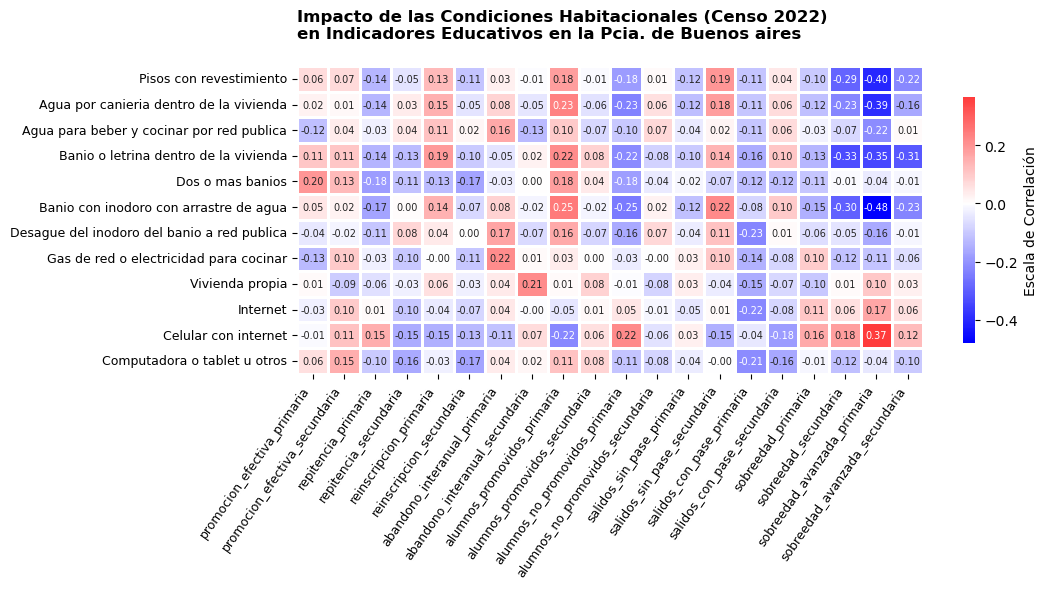

In [ ]:
# Creamos grafico
plt.figure(figsize=(11, 6))
ax = sns.heatmap(df_corr_subset, annot=True, annot_kws={"size": 7}, fmt=".2f", cmap="bwr", center=0, linewidths=1, cbar_kws={"shrink": 0.8, "label": "Escala de Correlación"})
plt.title("Impacto de las Condiciones Habitacionales (Censo 2022) \nen Indicadores Educativos en la Pcia. de Buenos aires", fontsize=12, pad=20, fontweight="bold", loc="left")
# Angulo de los ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, ha="right", fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

De este heatmap podemos extraer conclusiones para tomar en cuenta al diseñar nuestro modelo de predicción. Siguiendo el análisis preliminar anterior:

- "Baño con inodoro con arrastre de agua" tiene la correlación negativa más alta (-0.48) con sobreedad avanzada en primaria.
    - Una posible interpretación es que los municipios con mejor infraestructura sanitaria tienden a tener menos estudiantes con atraso escolar grave en primaria. Esto sugiere que condiciones básicas como saneamiento podrían favorecer el desarrollo educativo.

- "Pisos con revestimiento" tiene la segunda mayor correlación negativa, siendo esta una correlación moderada (-0.40) con sobreedad avanzada en primaria.
    - Una interpretacion que se puede considerar es que una mayor calidad de vivienda está asociada a un menor atraso escolar en primaria, reforzando el vínculo entre entorno y rendimiento educativo.

- En general, se observa que las condiciones habitacionales que reflejan falta de recursos básicos se correlacionan de forma positiva y débil con algunos indicadores que implican un resultado positivo en la educación, principalmente en la primaria.
    - Por ejemplo, la reinscripción de alumnos en primaria (0.13 a 0.19) y la promoción de alumnos en primaria (0.16 a 0.25).
- Mientras que por otro lado, estas también se correlacionan negativamente de forma moderada y débil con los indicadores que implican un resultado negativo en la cursada escolar. Nuevamente, esto se da principalmente en la primaria.
    - Por ejemplo, la repitencia de alumnos en primaria (-0.14 a -0.17), los alumnos no promovidos en primaria (-0.16 a -0.25), la sobreedad en primaria (-0.11 a -0.15), la sobreedad en secundaria (-0.23 a -0.33), y finalmente, la sobreedad avanzada en primaria (-0.35 a -0.48) y la sobreedad avanzada en secundaria (-0.16 a -0.31).
- Esto indica que los recursos básicos son esenciales para garantizar la continuidad escolar de los estudiantes, principalmente en primaria, ya que las condiciones habitacionales influyen con más fuerza en esos indicadores.
    - *Nota: Se propone como posible extension de la exploración poder identificar los hogares con niños en la primaria presentes y recrear el experimento con esa base de datos.*
    - *Nota (2): recordar que la promoción de alumnos en primaria tiene una relación (1:1) con la no promoción de alumnos en primaria, siendo una la inversa de la otra.*

- Por otro lado, "Celular con internet" tiene correlación positiva con la sobreedad avanzada en primaria (0.37). Una posible explicación es que el acceso a celulares sin supervisión podría distraer a los niños o reflejar desigualdades en el uso educativo de la tecnología, ya que no debemos olvidar que los datos sobre condiciones habitacionales son sobre hogares, y estos no discriminan si hay o no niños en los hogares encuestados.

- La condicion de poseer vivienda propia muestra correlaciones débiles (entre -0.10 y 0.10), sugiriendo que la tenencia de vivienda no es un factor determinante por sí solo.

- "Agua para beber por red pública" tiene correlaciones cercanas a cero (0.01 a 0.07) con la mayoría de indicadores educativos. Una posible razón es que el servicio podría estar universalizado en muchos municipios, reduciendo su poder discriminativo.

- "Dos o más baños" no muestra correlaciones fuertes (máx. 0.19), indicando que la cantidad de baños es menos relevante que su calidad (ej: arrastre de agua).


Cabe destacar también que este análisis no es lo suficientemente exhaustivo, pues también estamos tomando en consideración aquellos hogares que NO tienen niños presentes. Es por esto mismo que propusimos una extension al análisis donde solo se consideren hogares con esta condición.


Con este análisis, proponemos un cambio de hipótesis a una que se adapte mejor a lo que pudimos observar. Véase:

> *La falta de saneamiento básico está más asociada al atraso escolar que al abandono inmediato en el ciclo escolar primario.*

Creemos que esta hipótesis se adapta mejor a lo que pudimos observar, y se puede justificar con las conclusiones que comentamos anteriormente. Principalmente debemos destacar que los indicadores considerados condiciones básicas tienen mayor correlación con la sobreedad avanzada en primaria, mientras que aquellos indicadores que tratan al abandono tienen una correlación más débil, que puede ser contraintuitivo a lo que uno se esperaría.

Consideramos como saneamiento básico los siguientes indicadores:
- Pisos con revestimiento
- Agua por cañeria dentro de la vivienda
- Baño o letrina dentro de la vivienda
- Baño con inodoro con arrastre de agua
- Desagüe del inodoro del banio a red pública

El siguiente gráfico presenta las correlaciones destacadas con estos indicadores:

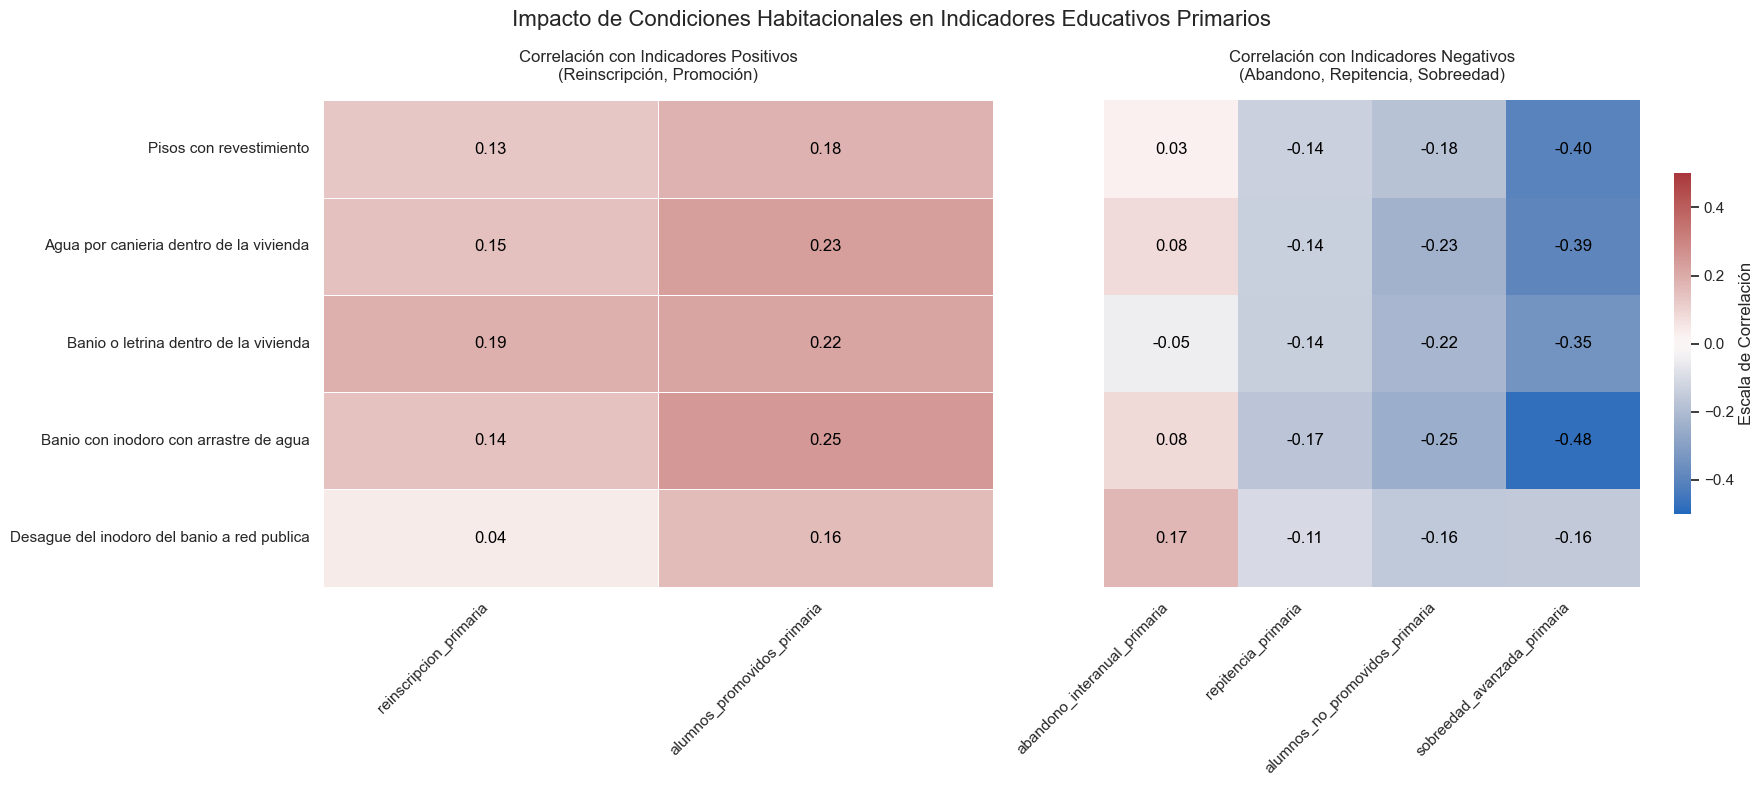

In [ ]:
# Correlaciones negativas
df_corr_subset_negativas = (df_corr_subset
                            .drop(labels=['Agua para beber y cocinar por red publica', 'Dos o mas banios', 'Gas de red o electricidad para cocinar', 'Vivienda propia', 'Internet', 'Celular con internet', 'Computadora o tablet u otros'], axis=0)
                            .copy()[['abandono_interanual_primaria', 'repitencia_primaria', 'alumnos_no_promovidos_primaria','sobreedad_avanzada_primaria']])
# Correlaciones positivas
df_corr_subset_positivas = (df_corr_subset
                            .drop(labels=['Agua para beber y cocinar por red publica', 'Dos o mas banios', 'Gas de red o electricidad para cocinar', 'Vivienda propia', 'Internet', 'Celular con internet', 'Computadora o tablet u otros'], axis=0)
                            .copy()[['reinscripcion_primaria', 'alumnos_promovidos_primaria']])

# Configuracion gral para ambos heatmaps
plt.figure(figsize=(18, 8))
sns.set(font_scale=1.0)
cmap = "vlag"
annot_kws = {"size": 12, "color": "black"}

# Correlaciones negativas (indicadores "malos")
plt.subplot(1, 2, 2)
ax1 = sns.heatmap(df_corr_subset_negativas, annot=True, fmt=".2f", cmap=cmap, center=0, vmin=-0.5, vmax=0.5, annot_kws=annot_kws, cbar_kws={"shrink": 0.7, "label": "Escala de Correlación", })
# Correlaciones positivas (indicadores "buenos")
plt.subplot(1, 2,1 )
ax2 = sns.heatmap(df_corr_subset_positivas, annot=True, fmt=".2f", cmap=cmap, center=0, vmin=-0.5, vmax=0.5, linewidths=0.5, annot_kws=annot_kws, cbar=False)

ax1.set_title("Correlación con Indicadores Negativos\n(Abandono, Repitencia, Sobreedad)", pad=15, fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.set_yticklabels([])
ax2.set_title("Correlación con Indicadores Positivos\n(Reinscripción, Promoción)", pad=15, fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
# Ajustes finales
plt.suptitle("Impacto de Condiciones Habitacionales en Indicadores Educativos Primarios", fontsize=16)
plt.tight_layout()
plt.show()

#### Modelado de ajuste lineal

Ahora podemos crear nuestro modelo de predicción de indicadores educativos tomando en consideración las conclusiones del análisis anterior.

Decidimos usar como variables predictoras a las columnas de condiciones de saneamiento básicas y variable objetivo a la tasa de sobreedad avanzada en primaria.

Notar que la elección no es arbitraria, pues es la variable con mayor correlación con las condiciones habitacionales, pero no se descarta crear un modelo que intentase predecir cualquiera de los indicadores restantes, o inclusive intentar predecir multiples variables a la vez, ya que existe correlación entre ellas.

Primero, renombramos las columnas de nuestras variables predictoras:

In [136]:
# Cambiamos nombres de las columnas de condiciones basicas
df_testing = df.rename(columns={'Pisos con revestimiento':'piso_revestimiento' ,
                                'Agua por canieria dentro de la vivienda':"agua_canieria_dentro",
                                'Banio o letrina dentro de la vivienda':"banio_dentro",
                                'Banio con inodoro con arrastre de agua':'banio_arrastre',
                                'Desague del inodoro del banio a red publica':'desague_red_publica'})

Ahora creemos las matrices de diseño y de predicción. Primero, intentemos con  lo más simple: un modelo lineal univariado, tomando la condición de baño con arrastre de agua como variable predictora.

In [138]:
#Definimos las variables predictoras y el objetivo
X = df_testing[['banio_arrastre']]
y = df_testing['sobreedad_avanzada_primaria']

Planteamos un modelo que no utiliza el método de división en conjunto de entrenamiento y testeo.

In [142]:
modelo_no_split = LinearRegression(fit_intercept=True)
modelo_no_split.fit(X, y)
y_pred = modelo_no_split.predict(X)

# Métricas de bondad
print("R² sin train-test:", r2_score(y, y_pred))
print("RMSE sin train-test:", np.sqrt(mean_squared_error(y, y_pred)))

R² sin train-test: 0.229669058344812
RMSE sin train-test: 0.3838233380567956


Logramos un R² de 0.22, lo cual puede parecer catastrófico a primera vista.
En general, un R² de 0.22 no se considera un buen R², pues esto significa que  que solo el 20% de la variabilidad total es explicada por el modelo, por tanto el modelo no explica la mayor parte de la variabilidad.

Pero esto nos lleva a pensar que quizas necesitaríamos usar un modelo con división con entrenamiento y testeo. En particular estamos trabajando con los 135 municipios de Buenos Aires, lo cual no conforma un conjunto de datos robusto (> 200).

Creemos varios modelos, y veamos si sus coeficientes R² al no fijar la semilla son muy distintas:

In [154]:
np.linspace(0.1, 0.5, 5)

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [181]:
for size in np.linspace(0.15, 0.5, 20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
    modelo_split = LinearRegression(fit_intercept=True)
    modelo_split.fit(X_train, y_train)
    y_pred = modelo_split.predict(X_test)
    #print(f"R² con test_size={round(size,2)} :", round(r2_score(y_test, y_pred), 2))

R² con test_size=0.15 : 0.19
R² con test_size=0.17 : 0.28
R² con test_size=0.19 : 0.57
R² con test_size=0.21 : 0.11
R² con test_size=0.22 : 0.42
R² con test_size=0.24 : 0.02
R² con test_size=0.26 : 0.05
R² con test_size=0.28 : 0.21
R² con test_size=0.3 : 0.33
R² con test_size=0.32 : -0.03
R² con test_size=0.33 : 0.08
R² con test_size=0.35 : 0.37
R² con test_size=0.37 : 0.17
R² con test_size=0.39 : -0.13
R² con test_size=0.41 : 0.15
R² con test_size=0.43 : 0.13
R² con test_size=0.44 : 0.26
R² con test_size=0.46 : 0.15
R² con test_size=0.48 : 0.16
R² con test_size=0.5 : 0.1


No parecen tener mucho que ver ... pero, ¿qué pasa si iteramos sobre el mismo tamaño del conjunto de testeo?

Analicemos la sensibilidad al tamaño del conjunto de testeo:

In [182]:
for size in np.linspace(0.15, 0.5, 20):
    r_cuadrados = []
    for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
        modelo_split = LinearRegression(fit_intercept=True)
        modelo_split.fit(X_train, y_train)
        y_pred = modelo_split.predict(X_test)
        r_cuadrados.append(r2_score(y_test, y_pred))
    print(f"R² con test_size={round(size,2)} :", round(np.array(r_cuadrados).mean(), 2))

R² con test_size=0.15 : 0.14
R² con test_size=0.17 : 0.18
R² con test_size=0.19 : 0.19
R² con test_size=0.21 : 0.19
R² con test_size=0.22 : 0.15
R² con test_size=0.24 : 0.14
R² con test_size=0.26 : 0.16
R² con test_size=0.28 : 0.19
R² con test_size=0.3 : 0.18
R² con test_size=0.32 : 0.17
R² con test_size=0.33 : 0.17
R² con test_size=0.35 : 0.2
R² con test_size=0.37 : 0.2
R² con test_size=0.39 : 0.2
R² con test_size=0.41 : 0.19
R² con test_size=0.43 : 0.18
R² con test_size=0.44 : 0.2
R² con test_size=0.46 : 0.2
R² con test_size=0.48 : 0.18
R² con test_size=0.5 : 0.18


Claramente el modelo parece que tener una baja variabilidad, pues el rango de R² esta entre 0.15 y 0.2.

Esto nos muestra que el modelo es robusto a cambios en el tamaño del conjunto de testeo, por tanto no debe depender de como se dividan los datos.

Podemos concluir de esta forma, que los modelos que creemos

In [ ]:
# con cross-val
res = cross_val_score(LinearRegression(), X, y, cv=3, scoring='r2') # 3 folds
print("\nR² promedio:", res.mean())
print("Variabilidad (std):", res.std())